# Imports, Reproducibility, Config

In [2]:

import os, json, random, math, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils

from sklearn.metrics import classification_report, confusion_matrix
import itertools

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


from pathlib import Path
DATA_ROOT = Path("/kaggle/input/a-dataset-of-citrus-fruit-images/A Dataset of Citrus Fruit Images/CitrusFruit/Augmentation")

train_dir = DATA_ROOT / "Train-A"
val_dir   = DATA_ROOT / "Val-A"
test_dir  = DATA_ROOT / "Test-A"

print("Train exists?", train_dir.exists())
print("Val exists?", val_dir.exists())
print("Test exists?", test_dir.exists())

IM_SIZE    = 224
BATCH_SIZE = 32
NUM_WORKERS= 2
MAX_EPOCHS = 20
EARLY_STOP_PATIENCE = 4

Device: cpu
Train exists? True
Val exists? True
Test exists? True


# 1)Transforms, Datasets, DataLoaders

In [3]:
# ==========================================
# 1) Transforms & Datasets (Train / Val / Test)
# ==========================================
train_tfms = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_dir = DATA_ROOT / "Train-A"
val_dir   = DATA_ROOT / "Val-A"
test_dir  = DATA_ROOT / "Test-A"

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)

CLASSES = train_ds.classes
NUM_CLASSES = len(CLASSES)
print("Classes:", CLASSES, " | NUM_CLASSES:", NUM_CLASSES)

# Save mapping for later use (Streamlit etc.)
with open("class_to_idx.json","w") as f:
    json.dump(train_ds.class_to_idx, f, indent=2)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

for name, dl in [("Train",train_loader),("Val",val_loader),("Test",test_loader)]:
    print(f"{name}: {len(dl.dataset)} images, {len(dl)} batches")


Classes: ['murcott', 'ponkan', 'tangerine', 'tankan']  | NUM_CLASSES: 4
Train: 5796 images, 182 batches
Val: 1650 images, 52 batches
Test: 138 images, 5 batches


# 2) Model Definition (Depthwise‑Separable + Residual)

In [ ]:
# ==========================================
# 2) Model: Custom CNN (Depthwise-Separable + Residual)  (By Deb)
# ==========================================
class DepthwiseSeparableConv(nn.Module):
    """
    DW conv (groups=in_ch, k=3) + BN + ReLU  ->  PW conv (1x1) + BN + ReLU
    """
    def __init__(self, in_ch, out_ch, stride=1, p_drop=0.0):
        super().__init__()
        self.dw = nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=stride, padding=1, groups=in_ch, bias=False)
        self.dw_bn = nn.BatchNorm2d(in_ch)
        self.pw = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        self.pw_bn = nn.BatchNorm2d(out_ch)
        self.drop = nn.Dropout(p_drop) if p_drop>0 else nn.Identity()

    def forward(self, x):
        x = F.relu(self.dw_bn(self.dw(x)), inplace=True)
        x = F.relu(self.pw_bn(self.pw(x)), inplace=True)
        x = self.drop(x)
        return x

class ResidualBlock(nn.Module):
    """
    Residual wrapper around a DS-Conv block. Projection used if channels/stride differ.
    """
    def __init__(self, in_ch, out_ch, stride=1, p_drop=0.0):
        super().__init__()
        self.conv = DepthwiseSeparableConv(in_ch, out_ch, stride=stride, p_drop=p_drop)
        self.proj = None
        if stride != 1 or in_ch != out_ch:
            self.proj = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch),
            )

    def forward(self, x):
        out = self.conv(x)
        res = x if self.proj is None else self.proj(x)
        return F.relu(out + res, inplace=True)

class CitrusNet(nn.Module):
    """
    Stem -> [Res(DSConv)]x4 with channel growth -> GAP -> Dropout -> Linear
    ~0.6-1.2M params depending on widths; lightweight yet expressive.
    """
    def __init__(self, num_classes=4, width=(32,64,128,256), p_drop=0.15):
        super().__init__()
        w1, w2, w3, w4 = width
        # Stem: 3x3 conv stride=2 to quickly reduce spatial size
        self.stem = nn.Sequential(
            nn.Conv2d(3, w1, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(w1),
            nn.ReLU(inplace=True),
        )
        # Stages (each with downsample via stride=2 at the start of the stage)
        self.stage1 = ResidualBlock(w1,  w2, stride=1, p_drop=p_drop)  # keep size
        self.stage2 = ResidualBlock(w2,  w2, stride=1, p_drop=p_drop)
        self.stage3 = ResidualBlock(w2,  w3, stride=2, p_drop=p_drop)  # downsample
        self.stage4 = ResidualBlock(w3,  w3, stride=1, p_drop=p_drop)
        self.stage5 = ResidualBlock(w3,  w4, stride=2, p_drop=p_drop)  # downsample
        self.stage6 = ResidualBlock(w4,  w4, stride=1, p_drop=p_drop)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),      # Global Average Pool
            nn.Flatten(),
            nn.Dropout(0.30),
            nn.Linear(w4, num_classes)
        )

        # Kaiming init
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0); nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x); x = self.stage2(x)
        x = self.stage3(x); x = self.stage4(x)
        x = self.stage5(x); x = self.stage6(x)
        x = self.head(x)
        return x

model = CitrusNet(num_classes=NUM_CLASSES, width=(32, 64, 128, 256), p_drop=0.10).to(device)
print(model)


CitrusNet(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (stage1): ResidualBlock(
    (conv): DepthwiseSeparableConv(
      (dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (dw_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pw): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (pw_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (proj): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage2): ResidualBlock(
    (conv): DepthwiseSeparableConv(
      (dw): Conv2d(64

# 3) Optimizer, Scheduler, AMP, Early‑Stopping Settings

In [6]:
# ==========================================
# 3) Optimizer, Scheduler, AMP, Early-Stopping
# ==========================================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, verbose=True)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


/usr/local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_10/4073034100.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


# 4) Train/Val Loops (with AMP) + Early Stop on Macro‑F1

In [7]:
# ==========================================
# 4) Training / Validation Loops
# ==========================================
def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_targets, all_preds = [], []
    total_loss, total_correct, total = 0.0, 0, 0
    for imgs, targets in loader:
        imgs, targets = imgs.to(device), targets.to(device)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(imgs)
            loss = criterion(logits, targets)
        preds = torch.argmax(logits, dim=1)
        total_loss += loss.item() * targets.size(0)
        total_correct += (preds == targets).sum().item()
        total += targets.size(0)
        all_targets.extend(targets.detach().cpu().tolist())
        all_preds.extend(preds.detach().cpu().tolist())
    avg_loss = total_loss / total
    acc = total_correct / total
    # F1/precision/recall (macro for balanced view)
    report = classification_report(all_targets, all_preds, target_names=CLASSES, output_dict=True, zero_division=0)
    f1_macro = report["macro avg"]["f1-score"]
    return avg_loss, acc, f1_macro, np.array(all_targets), np.array(all_preds)

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}
best_f1 = -1.0
best_path = "custom_cnn_best.pt"
epochs_no_improve = 0

for epoch in range(1, MAX_EPOCHS+1):
    model.train()
    epoch_loss, epoch_correct, epoch_total = 0.0, 0, 0
    t0 = time.time()
    for imgs, targets in train_loader:
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(imgs)
            loss = criterion(logits, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item() * targets.size(0)
        epoch_correct += (logits.argmax(1) == targets).sum().item()
        epoch_total += targets.size(0)

    train_loss = epoch_loss / epoch_total
    train_acc  = epoch_correct / epoch_total

    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader)
    scheduler.step(val_f1)  # plateau on macro-F1

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    took = time.time()-t0
    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | {took:.1f}s | train_loss {train_loss:.4f} acc {train_acc:.4f} | val_loss {val_loss:.4f} acc {val_acc:.4f} f1 {val_f1:.4f}")

    # Early stopping on best macro-F1
    if val_f1 > best_f1 + 1e-4:
        best_f1 = val_f1
        epochs_no_improve = 0
        torch.save({
            "model_state": model.state_dict(),
            "class_to_idx": train_ds.class_to_idx,
            "im_size": IM_SIZE,
            "normalize_mean_std": ([0.485,0.456,0.406], [0.229,0.224,0.225]),
            "arch": "CitrusNet(DSConv+Residual)",
            "val_f1": best_f1,
        }, best_path)
        print(f"  ✓ Saved new best to {best_path} (val_f1={best_f1:.4f})")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOP_PATIENCE:
            print(f"  ✳ Early stopping at epoch {epoch} (no improvement for {EARLY_STOP_PATIENCE} epochs).")
            break

/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 01/20 | 618.7s | train_loss 0.9215 acc 0.6246 | val_loss 0.6985 acc 0.7048 f1 0.6749
  ✓ Saved new best to custom_cnn_best.pt (val_f1=0.6749)


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 02/20 | 463.4s | train_loss 0.7010 acc 0.7196 | val_loss 0.5159 acc 0.7945 f1 0.7870
  ✓ Saved new best to custom_cnn_best.pt (val_f1=0.7870)


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 03/20 | 467.1s | train_loss 0.5992 acc 0.7673 | val_loss 0.4597 acc 0.8515 f1 0.8463
  ✓ Saved new best to custom_cnn_best.pt (val_f1=0.8463)


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 04/20 | 467.7s | train_loss 0.4802 acc 0.8100 | val_loss 0.6966 acc 0.7933 f1 0.7808


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 05/20 | 445.2s | train_loss 0.4304 acc 0.8323 | val_loss 0.3503 acc 0.8727 f1 0.8671
  ✓ Saved new best to custom_cnn_best.pt (val_f1=0.8671)


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 06/20 | 442.6s | train_loss 0.3946 acc 0.8439 | val_loss 0.4467 acc 0.8703 f1 0.8700
  ✓ Saved new best to custom_cnn_best.pt (val_f1=0.8700)


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 07/20 | 443.6s | train_loss 0.3292 acc 0.8730 | val_loss 0.3149 acc 0.9097 f1 0.9088
  ✓ Saved new best to custom_cnn_best.pt (val_f1=0.9088)


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 08/20 | 477.1s | train_loss 0.2827 acc 0.8942 | val_loss 0.3262 acc 0.8964 f1 0.8936


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 09/20 | 446.7s | train_loss 0.2614 acc 0.9060 | val_loss 0.2910 acc 0.9091 f1 0.9089
  ✓ Saved new best to custom_cnn_best.pt (val_f1=0.9089)


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 10/20 | 438.1s | train_loss 0.2584 acc 0.9073 | val_loss 0.2489 acc 0.9236 f1 0.9226
  ✓ Saved new best to custom_cnn_best.pt (val_f1=0.9226)


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 11/20 | 445.8s | train_loss 0.2099 acc 0.9220 | val_loss 0.2606 acc 0.9152 f1 0.9146


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 12/20 | 446.7s | train_loss 0.2079 acc 0.9217 | val_loss 0.3497 acc 0.9061 f1 0.9051


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 13/20 | 465.1s | train_loss 0.2022 acc 0.9239 | val_loss 0.2415 acc 0.9176 f1 0.9164


/tmp/ipykernel_10/1901612855.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 14/20 | 454.3s | train_loss 0.1649 acc 0.9377 | val_loss 0.2878 acc 0.9230 f1 0.9227
  ✳ Early stopping at epoch 14 (no improvement for 4 epochs).


# 5) Curves (Loss, Accuracy, Macro‑F1)

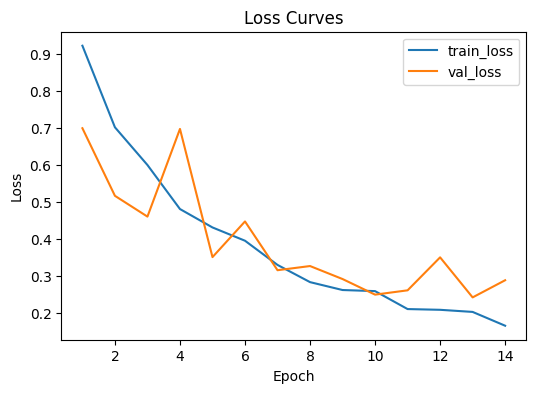

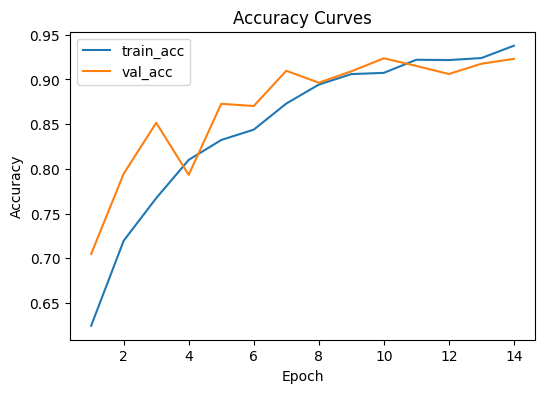

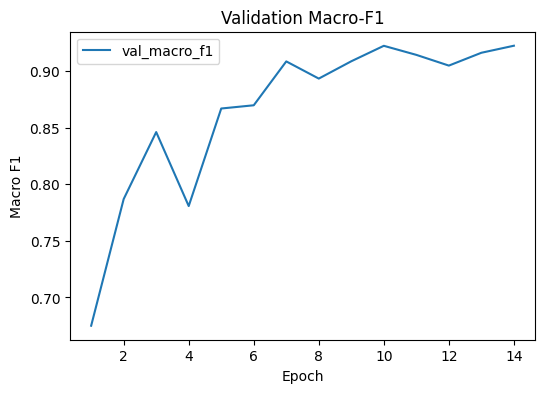

In [10]:
# ==========================================
# 5) Curves: loss & accuracy & F1
# ==========================================
def plot_curves(history):
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(6,4)); 
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"],   label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves"); plt.legend(); plt.show()

    plt.figure(figsize=(6,4)); 
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"],   label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curves"); plt.legend(); plt.show()

    plt.figure(figsize=(6,4)); 
    plt.plot(epochs, history["val_f1"], label="val_macro_f1")
    plt.xlabel("Epoch"); plt.ylabel("Macro F1"); plt.title("Validation Macro-F1"); plt.legend(); plt.show()

plot_curves(history)


# 6) Final Test Evaluation + Confusion Matrix

/tmp/ipykernel_10/1901612855.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


TEST | loss 0.1245 | acc 0.9710 | macro-F1 0.9705

Classification Report (Test):

              precision    recall  f1-score   support

     murcott       0.96      0.96      0.96        28
      ponkan       0.92      1.00      0.96        33
   tangerine       1.00      0.93      0.96        40
      tankan       1.00      1.00      1.00        37

    accuracy                           0.97       138
   macro avg       0.97      0.97      0.97       138
weighted avg       0.97      0.97      0.97       138



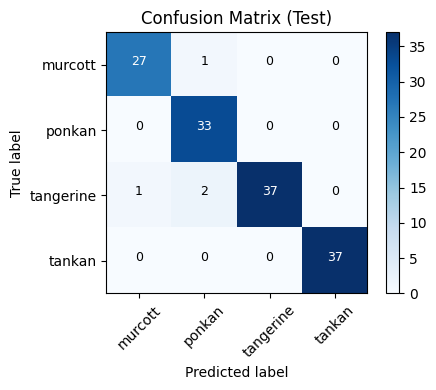


Best weights saved at: custom_cnn_best.pt


In [ ]:
# ==========================================
# 6) Final Test Evaluation (once) (By Deb)
# ==========================================
# Load best
ckpt = torch.load(best_path, map_location="cpu")
model.load_state_dict(ckpt["model_state"])
model.to(device)
test_loss, test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader)
print(f"TEST | loss {test_loss:.4f} | acc {test_acc:.4f} | macro-F1 {test_f1:.4f}")

print("\nClassification Report (Test):\n")
print(classification_report(y_true, y_pred, target_names=CLASSES, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test)"); plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, CLASSES, rotation=45); plt.yticks(tick_marks, CLASSES)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black", fontsize=9)
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout(); plt.show()

print(f"\nBest weights saved at: {best_path}")
